In [12]:
import itertools
import sys
sys.path.append("..")

from matplotlib import pyplot as plt
plt.style.use("ggplot")

from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer


# ECG classification

Machine learning spreads to day to day life with an immense speed. From medicine, industry to day to day life. It is helping or at least it should help people to make their life simpler. These are some areas, you probably even did not know that are heavily employing maching learning to improve their effectivness, costs or quality:

 - Traffic control - Intelligent traffic lights are varying green light time in order to minimize traffic jams.
 - Weather forecast - Many variables are influencing what the weather will be tommorrow, thus using past data to predict future state.
 - Medicine - With increasing amount of medical data, AI has to filter relevant information or help to do a better diagnosis.
 - Self-driving cars - Autopilot is one of the most known examples of AI in computer vision.
 - Fraud detection - Detection of suspicious behavior, traffic, credit card usement is widely used.
 - Agriculture - automatic harvest detection, quality control or plant disease prediction.


In this short articles followed by a short code a simple demonstration of artificial intelligence on a real world data is used. With a little knowledge, many tasks may be automated and this is an example of how to do it. Please note that this code is task agnostic, there is no preliminary assumptions about input data, therefore with a little effort on modyfying dataloader, many one dimensional signal tasks may be solved.

## Dataset

In this short application, a simple classification of the ECG waveform is shown. A publicly available dataset [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat) is used to perform this task. Only arythmia dataset is used and it consists of 109446 samples divided into 5 categories.

![Categories](../assets/Screenshot%20from%202022-06-09%2022-53-30.png)



First, let's do some exploratory data analysis.

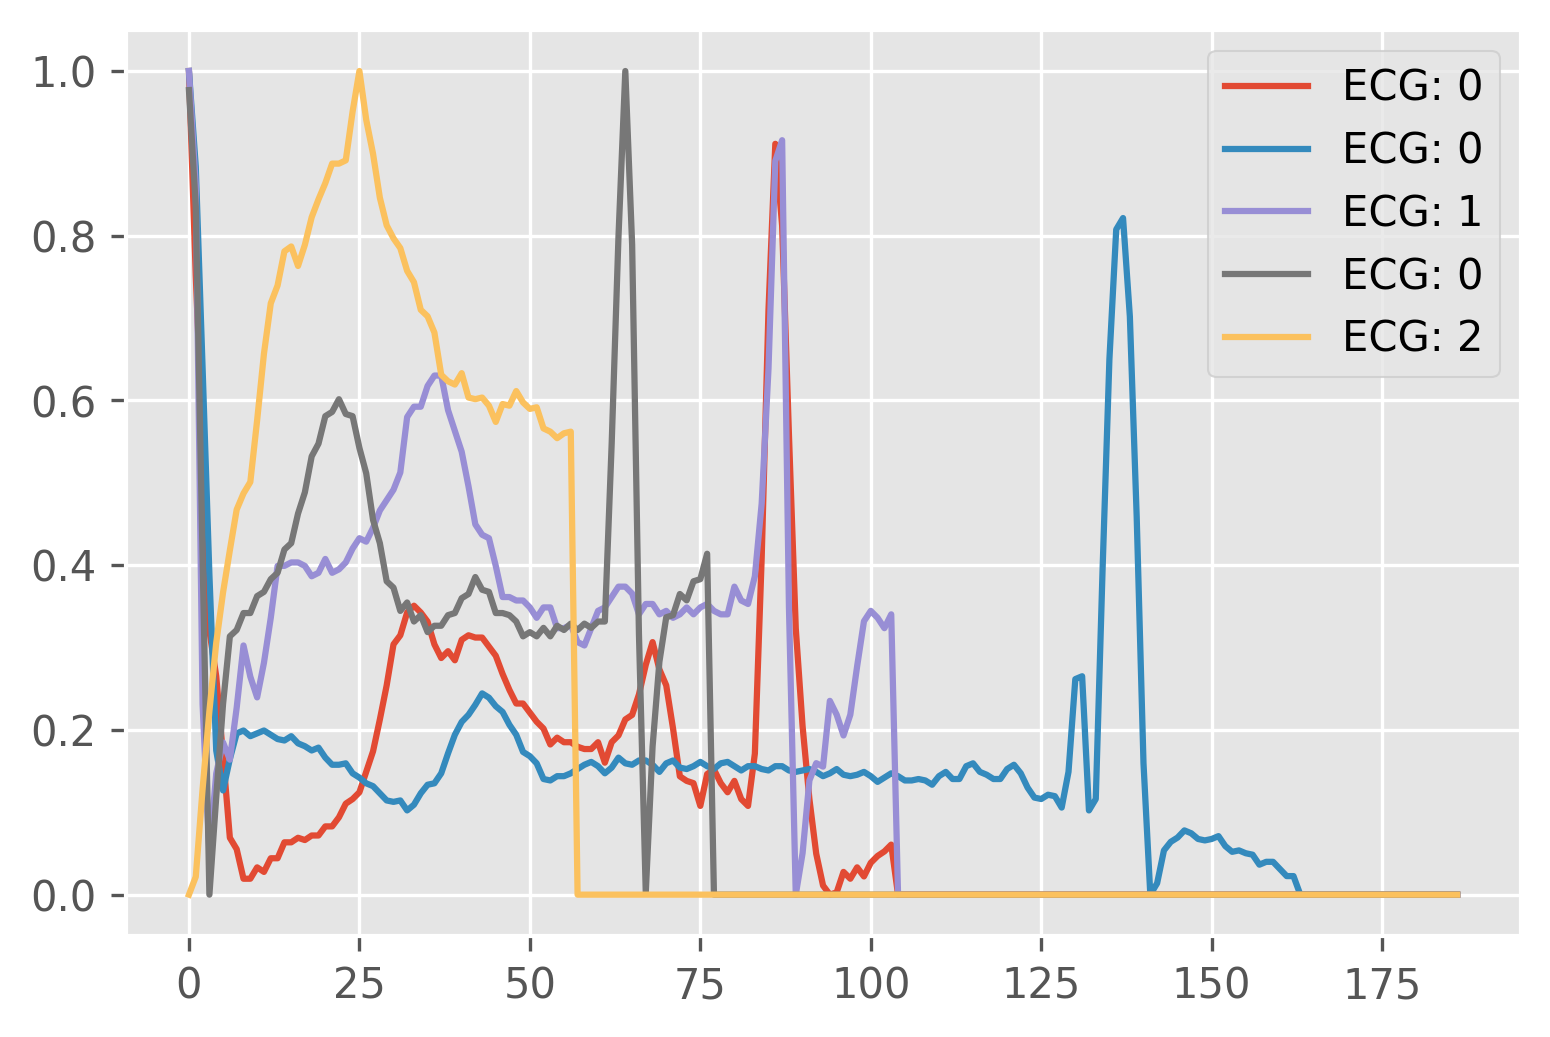

In [10]:
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(EcgConfig().dataset)

plt.figure(1, dpi=300)
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))
    
plt.legend([f"ECG: {label}" for label in labels])
plt.show()

Text(0.5, 0, 'Class')

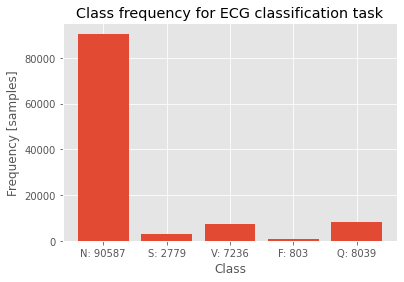

In [18]:
config = EcgConfig()
data_loaders = get_data_loaders(EcgConfig().dataset)
classes = ["N", "S", "V", "F", "Q"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
 

## Modeling
There are a variety of models available for this task, but for deomnstration, state of the art transformer like model is used. Transformers are models composed of one or multiple transformer encoder layers consisting of an MLP part and Attention part. MLP is a simple linear, fully connected layer with expansion. GELU is used as activation layer. Compared to ReLU, GELU has nonzero activation for negative input.

```python
class MLP(nn.Sequential):
    def __init__(self, input_channels, expansion=4):
        super().__init__(*[
            nn.Linear(input_channels, input_channels * expansion),
            nn.GELU(),
            nn.Linear(input_channels * expansion, input_channels)
        ])
```

Attention is the key component of transformer models. Mathematically, it is defined as:

\begin{equation}
Attention(Q, K, V) = \frac{\textbf{softmax(}QK^T\textbf{)}V}{\sqrt{d}},
\end{equation}
where K, Q, V are keys, queries and values respectively. For self-attention, Q, K, V are identical. In general, one may imagine attention as values tensor being weighted by $QK^T$ multiplication. Thus, values are weighted by an matrix representing importance of each element. A simple pytorch implementation of self-attention layer may look like the following snippet:

```python
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_size, num_heads, attention_store=None):
        super().__init__()
        self.queries_projection = nn.Linear(embed_size, embed_size)
        self.values_projection = nn.Linear(embed_size, embed_size)
        self.keys_projection = nn.Linear(embed_size, embed_size)
        self.final_projection = nn.Linear(embed_size, embed_size)
        self.embed_size = embed_size
        self.num_heads = num_heads

    def forward(self, x):
        assert len(x.shape) == 3
        keys = self.keys_projection(x)
        values = self.values_projection(x)
        queries = self.queries_projection(x)
        keys = einops.rearrange(keys, "b n (h e) -> b n h e", h=self.num_heads)
        queries = einops.rearrange(queries, "b n (h e) -> b n h e", h=self.num_heads)
        values = einops.rearrange(values, "b n (h e) -> b n h e", h=self.num_heads)
        energy_term = torch.einsum("bqhe, bkhe -> bqhk", queries, keys)
        divider = sqrt(self.embed_size)
        mh_out = torch.softmax(energy_term, -1)
        out = torch.einsum('bihv, bvhd -> bihd ', mh_out / divider, values)
        out = einops.rearrange(out, "b n h e -> b n (h e)")
        return self.final_projection(out)
```

When combining attention and MLPs, layernorm has to be used to keep tensor values in a reasonable range. Additionally, using this approach, position information is lost as matrix multiplication and linear layers are position agnostic. Thus, at the input of each transformer encoder layer a learnable position encoding is added. Inspired by ResNet, skip connections are used. Skip connection allow residual learning, prevents gradient vanishing and were the first known way of how to train very deep models with hundreds of layers. A basic transformer encoder layer is afterwards implemented as:

```python
class TransformerEncoderLayer(torch.nn.Sequential):
    def __init__(self, embed_size=768, expansion=4, num_heads=8):
        super(TransformerEncoderLayer, self).__init__(
            *[
                ResidualAdd(nn.Sequential(*[
                    nn.LayerNorm(embed_size),
                    MultiHeadAttention(embed_size, num_heads)
                ])),
                ResidualAdd(nn.Sequential(*[
                    nn.LayerNorm(embed_size),
                    MLP(embed_size, expansion)
                ]))
            ]
        )
```

After all encoder layers, the dimensionality of the problem is still preserved. The number of samples is still equal to the length of input sequence + 1. This additional item in input sequence length is given by classification token, which is added at the beginning. To reduce dimensionality, final classification layer is added. It first reduces dimensionality in sequence dimension by doing a simple mean. Finally, linear layers are used to reduce channel dimensions to the number of classes.

```python
class Classifier(nn.Sequential):
    def __init__(self, embed_size, num_classes):
        super().__init__(*[
            Reduce("b n e -> b e", reduction="mean"),
            nn.Linear(embed_size, embed_size),
            nn.LayerNorm(embed_size),
            nn.Linear(embed_size, num_classes)
        ])
```

Finally, combining all of these layers, a transformer is born.

```python
class ECGformer(nn.Module):

    def __init__(self, num_layers, signal_length, num_classes, input_channels, embed_size, num_heads, expansion) -> None:
        super().__init__()
        self.encoder = nn.ModuleList([TransformerEncoderLayer(
            embed_size=embed_size, num_heads=num_heads, expansion=expansion) for _ in range(num_layers)])
        self.classifier = Classifier(embed_size, num_classes)
        self.positional_encoding = nn.Parameter(torch.randn(signal_length + 1, embed_size))
        self.embedding = LinearEmbedding(input_channels, embed_size)

    def forward(self, x):
        embedded = self.embedding(x)

        for layer in self.encoder:
            embedded = layer(embedded + self.positional_encoding)

        return self.classifier(embedded)
```


This model will serve as a basic model for training. The input sequence length is 186, with classsification token, length becomes 187 samples.


In [ ]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model

# Training
No special training procedure is employed to do the actual training. The following settings are used:
- Learning rate - Determines the size of the step in the gradient direction. Too high learning rate leads to divergence, too low learning rate will slow down convergence. 0.0002 value is used for all experiments.
- Optimizer - Performs gradient descent. Simple gradient descent may lead to unstabilities leading to harder convergence of the algorithm, therefore tricks like momentum, adaptive momentum are used. This works uses solely Adam (adaptive momentum) optimizer.
- Batch size - How many samples are processed at once and used for gradient approximation. Lower values are worse approximation of the gradient of the entire dataset, but may be used as a good regularizer. This works uses 16, 32 or 64 sized batches.
- Augmentations - Creating a populated real-world dataset is hard. Therefore, real datasets are small. Augmentations are used to artificially increase the size of the dataset by using various tricks on data, like noise, rotation, scaling etc. This work will show results under some augmentations.
- Number of epochs - How many times is a single image passed through the network. This work is not designed to be SOTA, but rather educational, therefore 20 epochs are used.